In [54]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [3]:
def standardize_data(data):
    for row in data:
        tokens = row['tokens']
        for entity in row['entities']:
            entity.append(' '.join(tokens[entity[0]: entity[1]]))
        for relation in row['relations']:
            relation.append(' '.join(tokens[relation[0]: relation[1]]))
            relation.append(' '.join(tokens[relation[2]: relation[3]]))
    return data

In [4]:
with open('../asp/satisfiable.lp') as f:
    satisfiable_program = f.read()

In [5]:
with open('../asp/inference.lp') as f:
    inference_program = f.read()

In [8]:
with open('conll04_10_fold_10_unlabeled_prediction.json', 'r') as f:
    data = standardize_data(json.load(f))
# with open('conll04_10_fold_10_unlabeled_prediction.json', 'r') as f:
#     fold9 = json.load(f)
# with open('conll04_10_fold_10_unlabeled_prediction.json', 'r') as f:
#     fold8 = json.load(f)
# with open('conll04_10_fold_10_unlabeled_prediction.json', 'r') as f:
#     fold7 = json.load(f)
# with open('conll04_10_fold_10_unlabeled_prediction.json', 'r') as f:
#     fold6 = json.load(f)

In [7]:
import json
import subprocess
import ast

clingo_path = 'clingo'
clingo_options = ['--outf=2', '-n 0']
clingo_command = [clingo_path] + clingo_options

drive_command = ['clingo', '../asp/compute.lp',
                 '../asp/p2.lp', '../asp/p3.lp', '--outf=3']


def solve(program):
    input = program.encode()
    process = subprocess.Popen(clingo_command, stdin=subprocess.PIPE, stderr=subprocess.PIPE, stdout=subprocess.PIPE)
    output, error = process.communicate(input)
    result = json.loads(output.decode())
    if result['Result'] == 'SATISFIABLE' or result['Result'] == 'OPTIMUM FOUND':
        solutions = [value['Value'] for value in result['Call'][0]['Witnesses']]
        return union_all_solutions(solutions)
    else:
        return None
    
    
def solve_v2(program):
    # Write the program to a file
    with open('../asp/p3.lp', 'w') as f:
        f.write(program)
    process = subprocess.Popen(drive_command, stdin=subprocess.PIPE, stderr=subprocess.PIPE, stdout=subprocess.PIPE)
    output, error = process.communicate()
    result = ast.literal_eval(output.decode().split('\n')[-2])
    return result

In [42]:
def concat_facts(es, rs):
    output = []
    for e in es:
        output.append(e)
    for r in rs:
        output.append(r)
    return '\n'.join(output)

def union_all_solutions(solutions):
    union = set()
    for solution in solutions:
        for atom in solution:
            if not atom.startswith('nOfOKAtoms'):
                union.add(atom)
    return list(union)

def format_for_asp(s, type):
    if type == 'entity':
        return s.lower()
    else:
        splits = s.split('_')
        if len(splits) > 1:
            return '{}{}'.format(splits[0].lower(), splits[1].capitalize())
        return splits[0].lower()
    
def convert_original_to_atoms(data, dtype, wrap=True):
    result = []
    for d in data:
        if dtype == 'entity':
            if wrap:
                e = 'atom({}("{}")).'.format(format_for_asp(d[2], 'entity'),
                                             str(d[0]) + '+' + str(d[1]))
            else:
                e = '{}("{}").'.format(format_for_asp(d[2], 'entity'),
                                       str(d[0]) + '+' + str(d[1]))
            result.append(e)
        else:
            if wrap:
                r = 'atom({}("{}","{}")).'.format(format_for_asp(d[4], 'relation'),
                                             str(d[0]) + '+' + str(d[1]), str(d[2]) + '+' + str(d[3]))
            else:
                r = '{}("{}","{}").'.format(format_for_asp(d[4], 'relation'),
                                            str(d[0]) + '+' + str(d[1]), str(d[2]) + '+' + str(d[3]))
            result.append(r)
    return result


def convert_solutions_back(solution):
    es = []
    rs = []
    for atom in solution:
        atom = atom.replace('ok(', '', 1).replace(')', '', 1) + '.'
        if atom.startswith('loc(') or atom.startswith('peop(') or \
                atom.startswith('org(') or atom.startswith('other('):
            es.append(atom)
        else:
            rs.append(atom)
    return es, rs

In [43]:
def is_consistent(entities, relations, satisfiable_program, model_type, wrap=False):
    assert model_type in ['twoone', 'spert']
    if model_type == 'spert':
        entities = spert_to_twoone(entities, relations, 'entity')
        relations = spert_to_twoone(entities, relations, 'relation')

    e_atoms = convert_original_to_atoms(entities, 'entity', wrap)
    r_atoms = convert_original_to_atoms(relations, 'relation', wrap)
    program = satisfiable_program + '\n' + concat_facts(e_atoms, r_atoms)
    solution = solve(program)
    if solution:
        return True
    return False

In [44]:
def is_inferable(entities, relations, inference_program, model_type, wrap=False):
    assert model_type in ['twoone', 'spert']
    if model_type == 'spert':
        entities = spert_to_twoone(entities, relations, 'entity')
        relations = spert_to_twoone(entities, relations, 'relation')

    e_atoms = convert_original_to_atoms(entities, 'entity', wrap)
    r_atoms = convert_original_to_atoms(relations, 'relation', wrap)
    program = inference_program + '\n' + concat_facts(e_atoms, r_atoms)
    solution = solve(program)
    return len(solution) > len(entities) + len(relations)

In [45]:
def verify_and_infer(entities, relations, inference_program, model_type):
    assert model_type in ['twoone', 'spert']
    if model_type == 'spert':
        entities = spert_to_twoone(entities, relations, 'entity')
        relations = spert_to_twoone(entities, relations, 'relation')
    final_outputs = []
    # Remove connected components
    e_atoms = convert_original_to_atoms(entities, 'entity')
    r_atoms = convert_original_to_atoms(relations, 'relation')
    program = concat_facts(e_atoms, r_atoms)
    answer_sets = solve_v2(program)
    for answer_set in answer_sets:
        es, rs = convert_solutions_back(answer_set)
        # Inference starts here
        program = inference_program + '\n' + concat_facts(es, rs)
        solution = solve(program)
        if not solution:
            continue
        solution = ['ok(' + atom + ')' for atom in solution]
        es, rs = convert_solutions_back(solution)
        # Inference ends here
        final_outputs.append(es + rs)
    return final_outputs, e_atoms + r_atoms

In [12]:
sample = data[0]

In [74]:
# sample

In [24]:
is_consistent(sample['entities'], sample['relations'], satisfiable_program, 'twoone')

True

In [27]:
len(sample['entities']) + len(sample['relations'])

7

In [44]:
is_inferable(sample['entities'], sample['relations'], inference_program, 'twoone')

False

In [45]:
def consistent_but_inferable(data):
    num_consistent_but_inferable = 0
    num_inconsistent = 0
    for row in tqdm(data):
        if is_consistent(row['entities'], row['relations'], satisfiable_program, 'twoone'):
            if is_inferable(row['entities'], row['relations'], inference_program, 'twoone'):
                num_consistent_but_inferable += 1
        else:
            num_inconsistent += 1
    return num_consistent_but_inferable, num_inconsistent

In [96]:
def collect_inconsistent_samples(data):
    inconsistents = []
    indicies = []
    for i, row in enumerate(data):
        if not is_consistent(row['entities'], row['relations'], satisfiable_program, 'twoone'):
            inconsistents.append(row)
            indicies.append(i)
    return inconsistents, indicies

In [46]:
num_consistent_but_inferable, num_inconsistent = consistent_but_inferable(data)
print('Number of sentences that are consistent but inferable: ', num_consistent_but_inferable)
print('Number of sentences that are inconsistent: ', num_inconsistent)

100%|██████████| 830/830 [00:08<00:00, 98.80it/s] 

Number of sentences that are consistent but inferable:  0
Number of sentences that are inconsistent:  43


In [3]:
def missing_stats(data):
    ...

In [5]:
def redudant_stats(data):
    ...

In [22]:
def num_non_empty_entries(data, f1, f2):
    total_lens = []
    for row in data:
        ent_len = 0
        rel_len = 0
        for ent in row[f1]:
            ent_len += ent[1] - ent[0]
        for rel in row[f2]:
            rel_len += (rel[1] - rel[0]) * (rel[3] - rel[2])
        total_lens.append(ent_len + rel_len)
    return total_lens

In [75]:
total_lens_predicted = num_non_empty_entries(data, 'entities', 'relations')
total_lens_gt = num_non_empty_entries(data, 'entity_gts', 'relation_gts')

In [78]:
len([e for e in total_lens_predicted if e < 3])

19

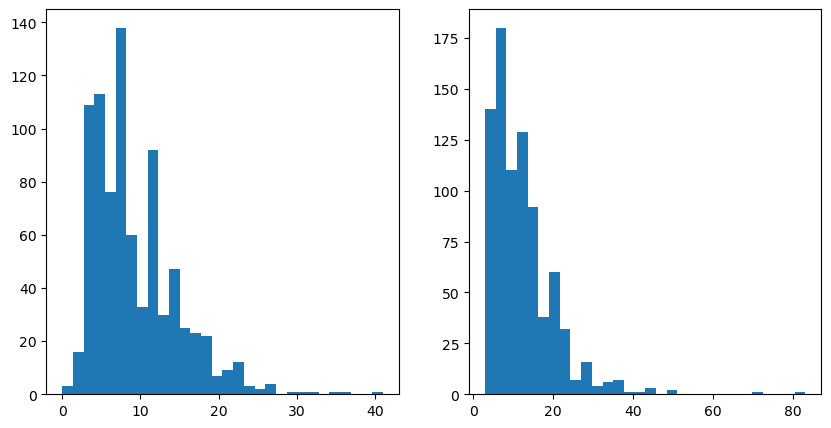

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].hist(total_lens_predicted, bins=30)
axes[1].hist(total_lens_gt, bins=30)
plt.show()

In [43]:
df = pd.DataFrame({'total_lens_predicted': total_lens_predicted, 
                   'total_lens_gt': total_lens_gt,
                   'sent_len': [len(row['tokens']) for row in data]
                  })

In [45]:
df.head()

,total_lens_predicted,total_lens_gt,sent_len
0,16,13,20
1,3,20,50
2,6,8,32
3,17,49,25
4,8,11,22


In [39]:
df.describe()

,total_lens_predicted,total_lens_gt
count,830.000000,830.000000
mean,9.255422,12.203614
std,5.495019,7.946032
min,0.000000,3.000000
25%,5.000000,7.000000
50%,8.000000,10.000000
75%,12.000000,16.000000
max,41.000000,83.000000


In [50]:
np.corrcoef(df['total_lens_predicted'], df['sent_len'])

array([[1.        , 0.32988423],
       [0.32988423, 1.        ]])

In [51]:
np.corrcoef(df['total_lens_gt'], df['sent_len'])

array([[1.        , 0.46573011],
       [0.46573011, 1.        ]])

In [28]:
def num_atoms_per_sentences(data):
    num_entities = []
    num_relations = []
    num_gt_entities = []
    num_gt_relations = []
    for row in tqdm(data):
        num_entities.append(len(row['entities']))
        num_relations.append(len(row['relations']))
        num_gt_entities.append(len(row['entity_gts']))
        num_gt_relations.append(len(row['relation_gts']))
    return num_entities, num_relations, num_gt_entities, num_gt_relations

In [29]:
num_entities, num_relations, num_gt_entities, num_gt_relations = num_atoms_per_sentences(data)

100%|██████████| 830/830 [00:00<00:00, 1200024.93it/s]


In [32]:
df = pd.DataFrame({'num_entities': num_entities, 'num_relations': num_relations, 
                   'num_gt_entities': num_gt_entities, 'num_gt_relations': num_gt_relations})

In [34]:
df.describe()

,num_entities,num_relations,num_gt_entities,num_gt_relations
count,830.000000,830.000000,830.000000,830.000000
mean,3.539759,1.159036,3.687952,1.401205
std,1.753916,0.919568,1.829981,0.946964
min,0.000000,0.000000,2.000000,1.000000
25%,2.000000,1.000000,2.000000,1.000000
50%,3.000000,1.000000,3.000000,1.000000
75%,4.000000,1.000000,4.000000,1.000000
max,24.000000,6.000000,24.000000,10.000000


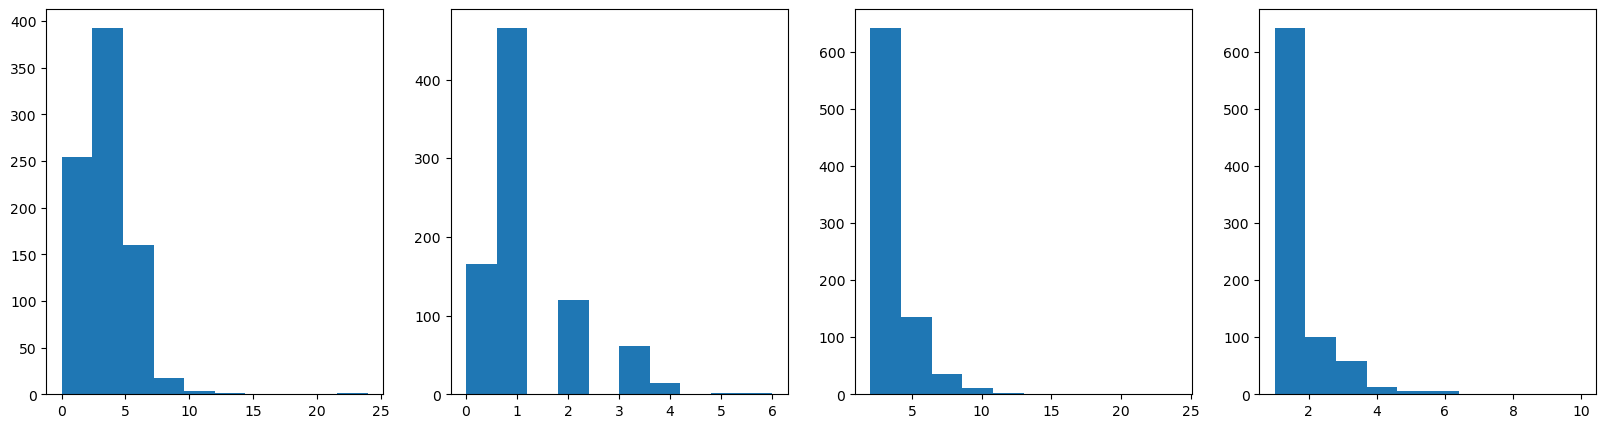

In [30]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 5))

axes[0].hist(num_entities, bins=10)
axes[1].hist(num_relations, bins=10)
axes[2].hist(num_gt_entities, bins=10)
axes[3].hist(num_gt_relations, bins=10)
plt.show()

In [72]:
print(np.mean(num_entities))
print(np.mean(num_relations))
print(np.mean(num_gt_entities))
print(np.mean(num_gt_relations))

3.539759036144578
1.1590361445783133
3.6879518072289157
1.4012048192771085


In [97]:
inconsistents, indicies = collect_inconsistent_samples(data)

In [73]:
# inconsistents

## Hypothesis 1: increase number of training points also increase the number of atoms per sentences

In [52]:
with open('../datasets/conll04_10/folds/10/labeled.json', 'r') as f:
    data_labeled = json.load(f)
with open('../datasets/conll04_10/folds/10/unlabeled.json', 'r') as f:
    data_unlabeled = json.load(f)

In [53]:
len(data_unlabeled)

830

In [56]:
indicies = list(range(830))
random.shuffle(indicies)

In [61]:
part1 = []
part2 = []
for i in indicies[:len(data_unlabeled) // 10]:
    part1.append(data_unlabeled[i])
    
for i in indicies[:2 * len(data_unlabeled) // 10]:
    part2.append(data_unlabeled[i])

In [62]:
print(len(part1))
print(len(part2))

83
166


In [63]:
with open('part1.json', 'w') as f:
    json.dump(part1, f)
    
with open('part2.json', 'w') as f:
    json.dump(part2, f)

In [ ]:
part0: {'entity_p': 0.7615894039663048, 
        'entity_r': 0.7460611677410004, 
        'entity_f1': 0.7537453255054033, 
        'relation_p': 0.5186246418189506, 
        'relation_r': 0.4289099525964713, 
        'relation_f1': 0.4695201127365709, 
        'relation_p_wNER': 0.5014326647420793, 
        'relation_r_wNER': 0.41469194311813523, 
        'relation_f1_wNER': 0.45395591047421013}

part1: {'entity_p': 0.7271889400854638, 
        'entity_r': 0.731232622792111, 
        'entity_f1': 0.729205182935376, 
        'relation_p': 0.4918918918785975, 
        'relation_r': 0.43127962084286064, 
        'relation_f1': 0.4595959685713191, 
        'relation_p_wNER': 0.4918918918785975, 
        'relation_r_wNER': 0.43127962084286064, 
        'relation_f1_wNER': 0.4595959685713191}
part2: {'entity_p': 0.8056828597543018, 
       'entity_r': 0.8146431881296141, 
       'entity_f1': 0.8101382555591455, 
       'relation_p': 0.5775656324444495, 
       'relation_r': 0.5734597156262213, 
       'relation_f1': 0.5755053591032984, 
       'relation_p_wNER': 0.5680190930652024, 
       'relation_r_wNER': 0.563981042640664, 
       'relation_f1_wNER': 0.5659928740210751}

In [64]:
with open('part0.prediction.json', 'r') as f:
    part0_pred = json.load(f)
    
with open('part1.prediction.json', 'r') as f:
    part1_pred = json.load(f)
    
with open('part2.prediction.json', 'r') as f:
    part2_pred = json.load(f)

In [69]:
total_lens_predicted = num_non_empty_entries(part0_pred, 'entities', 'relations')
total_lens_gt = num_non_empty_entries(part0_pred, 'entity_gts', 'relation_gts')

df = pd.DataFrame({'total_lens_predicted': total_lens_predicted, 
                   'total_lens_gt': total_lens_gt,
                   'sent_len': [len(row['tokens']) for row in part0_pred]
                  })

df.describe()

,total_lens_predicted,total_lens_gt,sent_len
count,288.000000,288.000000,288.000000
mean,10.170139,12.652778,28.944444
std,6.128321,9.134549,15.457834
min,0.000000,3.000000,2.000000
25%,6.000000,7.000000,20.000000
50%,9.000000,11.000000,27.000000
75%,13.000000,15.000000,37.000000
max,45.000000,77.000000,118.000000


In [70]:
total_lens_predicted = num_non_empty_entries(part1_pred, 'entities', 'relations')
total_lens_gt = num_non_empty_entries(part1_pred, 'entity_gts', 'relation_gts')

df = pd.DataFrame({'total_lens_predicted': total_lens_predicted, 
                   'total_lens_gt': total_lens_gt,
                   'sent_len': [len(row['tokens']) for row in part0_pred]
                  })

df.describe()

,total_lens_predicted,total_lens_gt,sent_len
count,288.000000,288.000000,288.000000
mean,10.739583,12.652778,28.944444
std,7.595494,9.134549,15.457834
min,1.000000,3.000000,2.000000
25%,6.000000,7.000000,20.000000
50%,9.000000,11.000000,27.000000
75%,13.000000,15.000000,37.000000
max,63.000000,77.000000,118.000000


In [71]:
total_lens_predicted = num_non_empty_entries(part2_pred, 'entities', 'relations')
total_lens_gt = num_non_empty_entries(part2_pred, 'entity_gts', 'relation_gts')

df = pd.DataFrame({'total_lens_predicted': total_lens_predicted, 
                   'total_lens_gt': total_lens_gt,
                   'sent_len': [len(row['tokens']) for row in part0_pred]
                  })

df.describe()

,total_lens_predicted,total_lens_gt,sent_len
count,288.000000,288.000000,288.000000
mean,11.649306,12.652778,28.944444
std,7.529635,9.134549,15.457834
min,1.000000,3.000000,2.000000
25%,7.000000,7.000000,20.000000
50%,10.000000,11.000000,27.000000
75%,15.000000,15.000000,37.000000
max,51.000000,77.000000,118.000000


## Hypothesis 2: model can predict the number of non-empty entries pretty well with less data